In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit

In [2]:
def lif_dynamics(tau_m, E_l, noise_std, stimulus, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps + 1)*dt

    sigma = np.sqrt(2.0 * noise_std * dt)
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=ntime_steps + 1)
    
    fixed_term = noise_vals + stimulus*dt

    v_m = np.zeros(ntime_steps + 1)
    v_m[0] = E_l
    t_spks = []
    # integration:
    t = 1
    while t < ntime_steps + 1:
        v_m[t] = v_m[t - 1] + ((-(v_m[t - 1] - E_l) * dt) + fixed_term[t])/tau_m
        if v_m[t] > v_t:
            v_m[t] = E_l
            t_spks.append(t*dt)
        t = t + 1

    return time_points, v_m, t_spks

In [3]:
tau_m = 0.023
e_l = -0.079
r_m = 10 # MOhm
v_t = -0.061

dt = 0.001
total_time = 5

noise_std = 2e-9
n_timepoints = int(total_time/dt) + 1
stimulus = np.ones(n_timepoints)*17.3*1e-3

#np.random.seed(1)
time, v_m, spks = lif_dynamics(tau_m, e_l, noise_std, stimulus, v_t, dt, total_time)

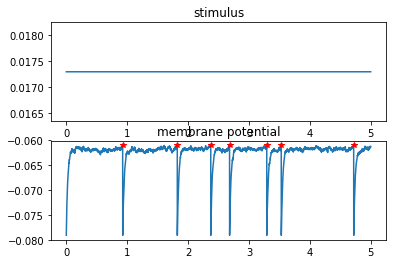

In [4]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(time, stimulus)
axes[0].set_title('stimulus')
axes[1].plot(time, v_m)
axes[1].set_title('membrane potential')
axes[1].plot(spks, np.ones(len(spks))*v_t, 'r*')

In [5]:
spks

[0.927, 1.824, 2.374, 2.6830000000000003, 3.294, 3.532, 4.722]

In [6]:
def g_syn(t, g_max, tau_syn):
    if t>= 0:
        return g_max * t / tau_syn * np.exp(-t/tau_syn)
    else:
        return 0

1.5


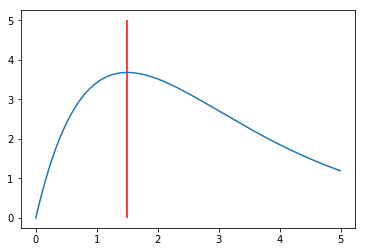

In [7]:
x = np.arange(500)*0.01
y = np.array([ g_syn(t, 10, 1.5) for t in x])
plt.plot(x, y)
ymax = np.argmax(y)
plt.vlines(x[ymax], 0, 5, 'r')
print(x[ymax])

## Stimulus generation (cf. Figure 1B and 1D of Bhattacharyya et. al 2017)

In [8]:
init_distance = 50 # in mm

def generate_stimulus(stim_size=1, speed=1, length=10, dt=0.1):
    timesteps = np.arange(int(length/dt))*dt
    distances = init_distance - timesteps*speed
    angles = np.arctan2(stim_size/2, distances)*2
    angles_degrees = angles/np.pi*180
    return timesteps, angles_degrees, distances

[ 52.63157895  26.31578947  17.85714286  13.51351351  10.75268817
   9.00900901]


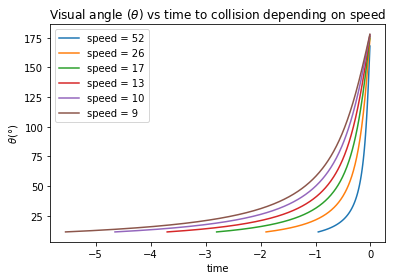

In [9]:
# these values are taken from Bhattacharyya et. al 2017:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, dt=0.01)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    plt.plot(t_to_collision, stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$\theta (\degree)$')
plt.title(r'Visual angle ($\theta$) vs time to collision depending on speed')
plt.legend()
#print(dists)

In [10]:
# from preuss2006:
10/600

0.016666666666666666

## Linear function of visual angle

In [94]:
def f_theta_linear(theta, m, b):
    return theta*m + b

def transform_stim(stim_size, speed, length, dt, m=1.5, b=0):
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, length=length, dt=dt)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    transformed_stim_to_collision = f_theta_linear(stim_to_collision, m=m, b=b)
    transformed_stims = f_theta_linear(stims, m=m, b=b)
    return t, stims, transformed_stims, dists, t_to_collision, transformed_stim_to_collision

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


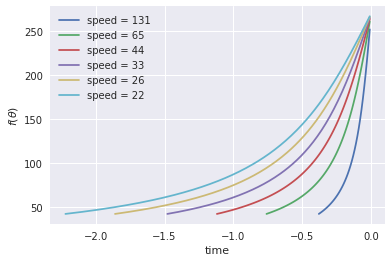

In [95]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
length = 10
dt = 0.01
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
    plt.plot(t_to_collision, transformed_stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$f(\theta)$')
plt.legend()
#print(dists)

## Leaky Integrate-and-Fire model of the Mauthner cell (adopted from Koyama et. al 2016)

In [96]:
def lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = e_l
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [97]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = 1

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
sigma = np.sqrt(2.0 * noise_std * dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)
print(spks[0])

1.41421356237e-09
0.0238


In [98]:
noise_vals.shape

(10000,)

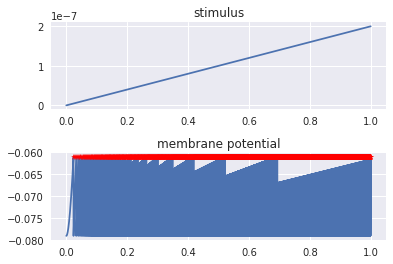

In [99]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(time, stimulus)
axes[0].set_title('stimulus')
axes[1].plot(time, v_m)
axes[1].set_title('membrane potential')
axes[1].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)

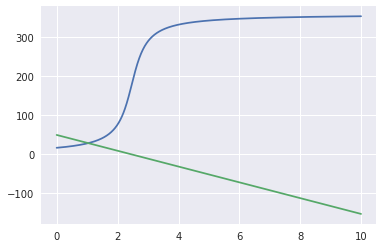

In [101]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
length = 10
dt = 0.01
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
speed = speeds[3]
t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
plt.plot(t, stims)
plt.plot(t, dists)

In [122]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.00001
total_time = 5

noise_std = 1*1e-4
n_timepoints = int(total_time/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
speeds = 1/(LV_vals/stim_size)
speed = speeds[5]

m = 5.5
b = 0

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, total_time, dt, m, b)

stimulus = tstims*1e-11
sigma = np.sqrt(2.0 * noise_std * dt)
#print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

Response angle at first spike: 29.0839280514 degree
Distance at first spike: 48.1882882883 mm


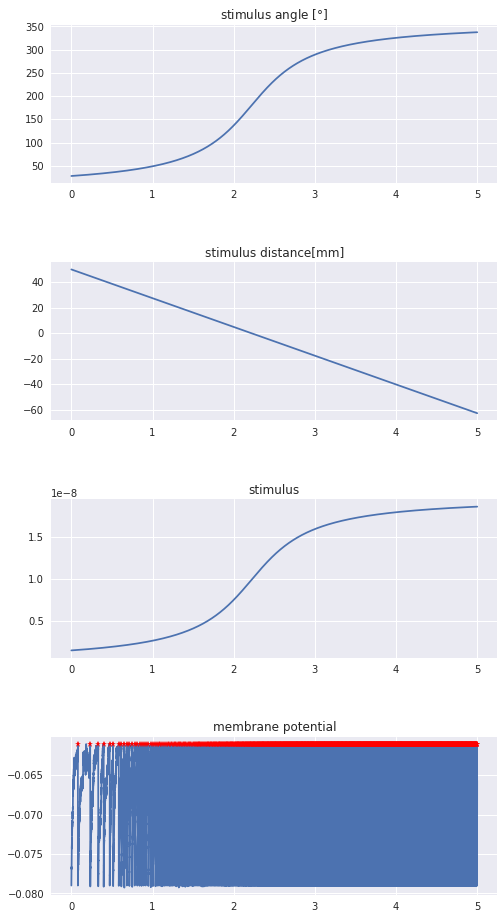

In [125]:
fig, axes = plt.subplots(4, 1, figsize=(8,16))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
axes[1].plot(time, dists)
axes[1].set_title('stimulus distance[mm]')
axes[2].plot(time, stimulus)
axes[2].set_title('stimulus')
axes[3].plot(time, v_m)
axes[3].set_title('membrane potential')
if not len(spks) == 0:
    axes[3].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

In [132]:
def calc_response(params):
    t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(params['stim_size'],
                                                                                    params['speed'],
                                                                                    params['total_time'],
                                                                                    params['dt'],
                                                                                    params['m'],
                                                                                    params['b'])

    stimulus = tstims*1e-11
    sigma = np.sqrt(2.0 * params['noise_std'] * params['dt'])
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc = jit_lif_dynamics(params['tau_m'],
                                            params['e_l'],
                                            params['r_m'],
                                            stimulus,
                                            noise_vals,
                                            params['v_t'],
                                            params['dt'],
                                            params['total_time'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
    #time_to_collision = 
    return stims[first_spike_idx], dists[first_spike_idx], first_spike

## One parameter set example

Mean visual angle: 169.975105038
Mean distance: 1.09786842105
Mean reaction time: 1.238854


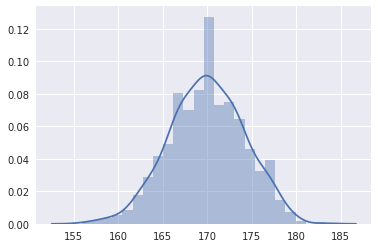

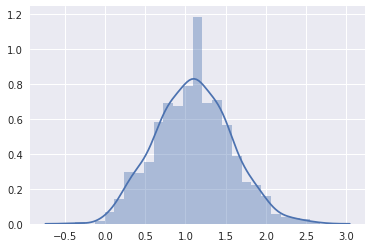

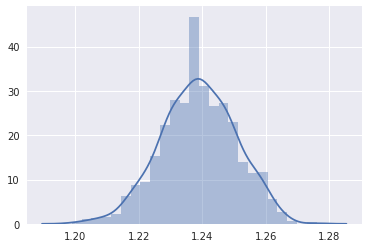

In [177]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'dt': 0.001,
          'stim_size': 25,
          'speed': speed,
          'total_time': 5,
          'noise_std': 0.1*1e-4,
          'n_timepoints': int(total_time/dt),
          'm': 1.1,
          'b': 0}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i] = calc_response(params)

import seaborn as sns
sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
print('Mean reaction time: ' + str(np.mean(reaction_times)))

## Analyzing the influence of m, b and noise

In [179]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'dt': 0.001,
          'stim_size': 25,
          'speed': speed,
          'total_time': 5,
          'noise_std': 5.5*1e-4,
          'n_timepoints': int(total_time/dt),
          'm': 4.5,
          'b': 0}

mvals = np.linspace(0.5, 10, num=10)
nmvals = len(mvals)
nspeeds = len(speeds)
nruns = 1000
rstims = np.zeros((nruns, nmvals, nspeeds))
rdists = np.zeros((nruns, nmvals, nspeeds))
reaction_times = np.zeros((nruns, nmvals, nspeeds))


for speed_idx, speed in enumerate(speeds):
    params['speed'] = speed
    for m_idx, mval in enumerate(mvals):
        params['m'] = mval
        for i in np.arange(nruns):
            rstims[i, m_idx, speed_idx], rdists[i, m_idx, speed_idx], reaction_times[i, m_idx, speed_idx] = calc_response(params)

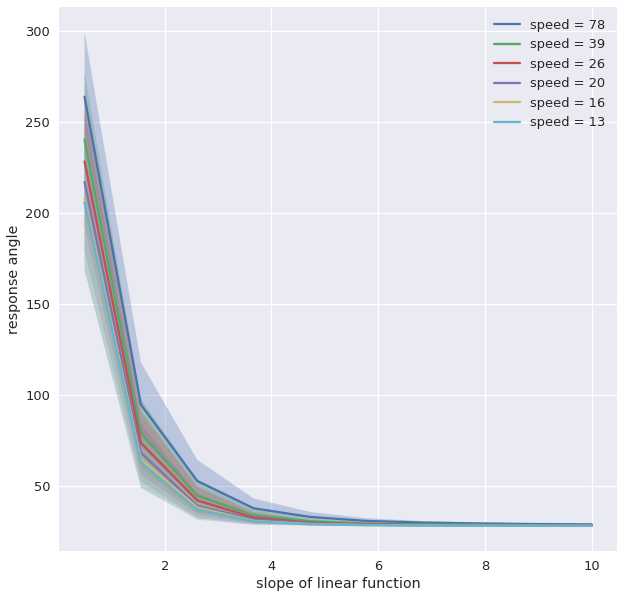

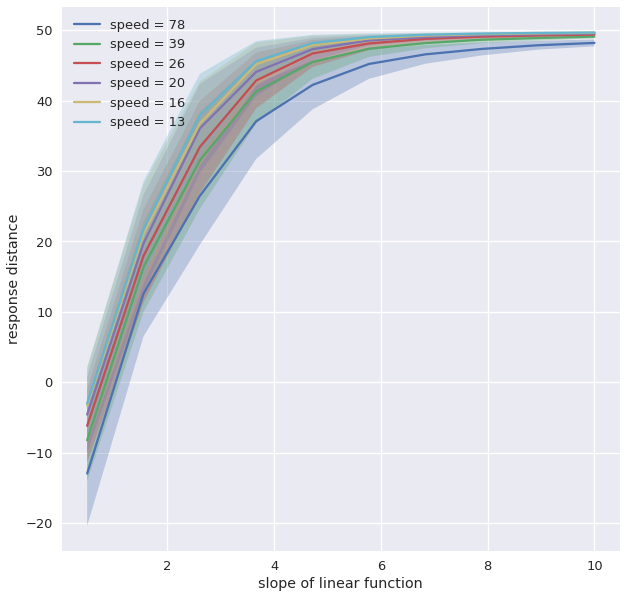

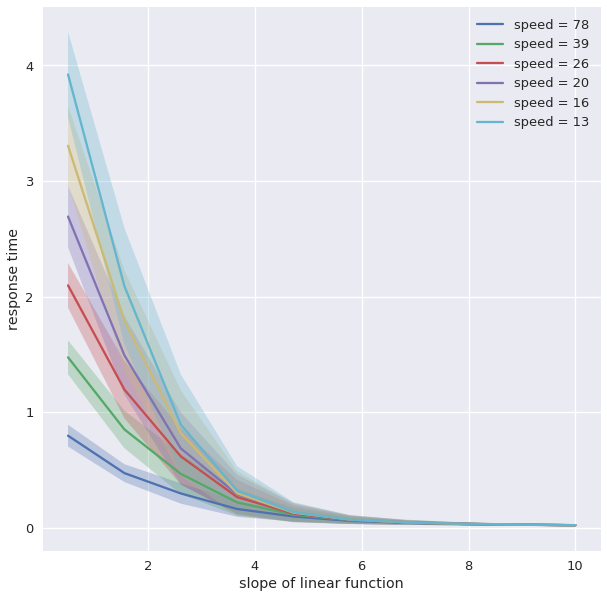

In [180]:
plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrstims = np.mean(rstims[:, :, speed_idx], axis=0)
    vrstims = np.std(rstims[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals, mrstims, label='speed = ' + str(int(speed)))
    plt.fill_between(mvals, mrstims-vrstims, mrstims+vrstims, alpha=0.3)
    plt.xlabel('slope of linear function')
    plt.ylabel('response angle')
plt.legend()

plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrdists = np.mean(rdists[:, :, speed_idx], axis=0)
    vrdists = np.std(rdists[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals, mrdists, label='speed = ' + str(int(speed)))
    plt.fill_between(mvals, mrdists-vrdists, mrdists+vrdists, alpha=0.3)
    plt.xlabel('slope of linear function')
    plt.ylabel('response distance')
plt.legend()

plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrtimes = np.mean(reaction_times[:, :, speed_idx], axis=0)
    vrtimes = np.std(reaction_times[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals, mrtimes, label='speed = ' + str(int(speed)))
    plt.fill_between(mvals, mrtimes-vrtimes, mrtimes+vrtimes, alpha=0.3)
    plt.xlabel('slope of linear function')
    plt.ylabel('response time')
plt.legend()

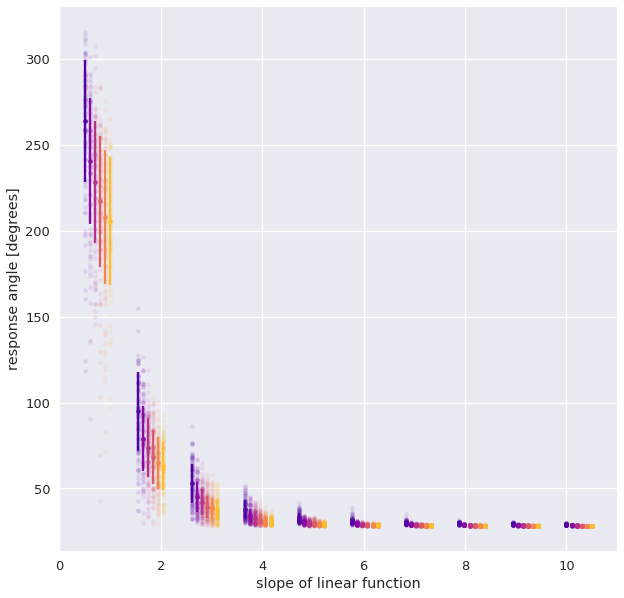

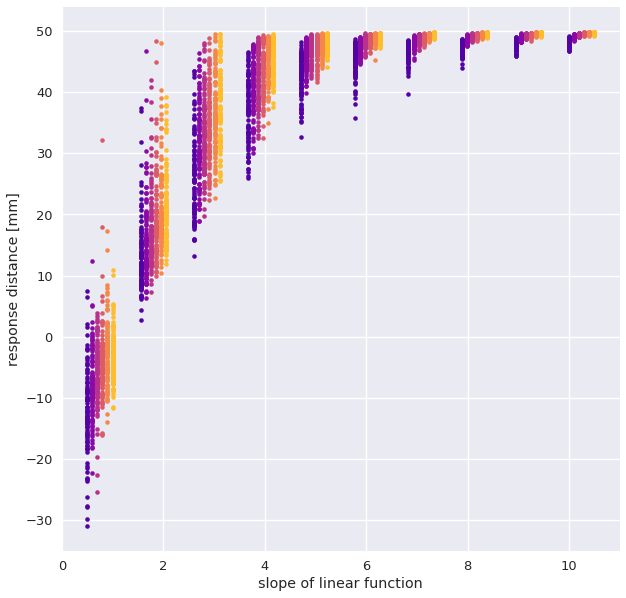

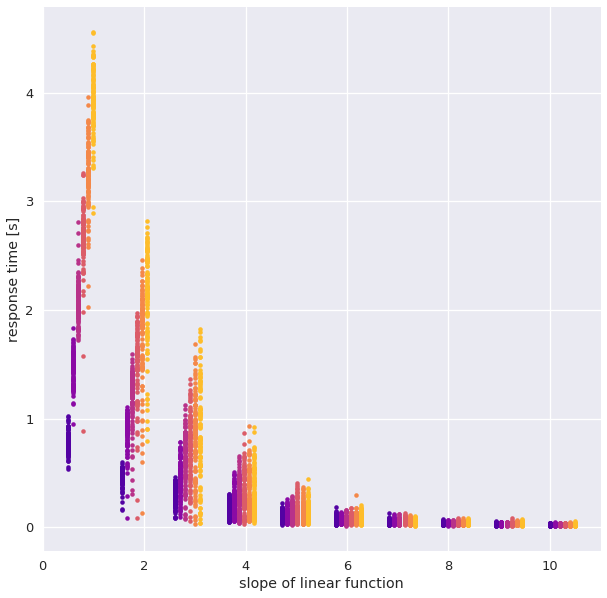

In [186]:
import matplotlib as mpl
sm = plt.cm.ScalarMappable(cmap=mpl.cm.plasma, norm=mpl.colors.Normalize(vmin=-1, vmax=6))

plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrstims = np.mean(rstims[:, :, speed_idx], axis=0)
    vrstims = np.std(rstims[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals+speed_idx*0.1, rstims[0:100:, :, speed_idx].T, '.', color=sm.to_rgba(speed_idx), alpha=0.1)
    errline, errcaps, errbars = plt.errorbar(mvals+speed_idx*0.1, mrstims,
                                             yerr=vrstims, fmt='.',
                                             color=sm.to_rgba(speed_idx))
    plt.xlabel('slope of linear function')
    plt.ylabel('response angle [degrees]')
plt.legend()

plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrdists = np.mean(rdists[:, :, speed_idx], axis=0)
    vrdists = np.std(rdists[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals+speed_idx*0.1, rdists[0:100:, :, speed_idx].T, '.', color=sm.to_rgba(speed_idx))
    plt.xlabel('slope of linear function')
    plt.ylabel('response distance [mm]')
plt.legend()

plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrtimes = np.mean(reaction_times[:, :, speed_idx], axis=0)
    vrtimes = np.std(reaction_times[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals+speed_idx*0.1, reaction_times[0:100:, :, speed_idx].T, '.', color=sm.to_rgba(speed_idx))
    plt.xlabel('slope of linear function')
    plt.ylabel('response time [s]')
plt.legend()

## Profiling the LIF integration function with python vs. cython

In [22]:
%load_ext Cython

In [23]:
%%cython
import numpy as np
cimport numpy as np
DTYPE = np.double
FTYPE = np.float
ITYPE = np.int
ctypedef np.double_t DTYPE_t
ctypedef np.float_t FTYPE_t
ctypedef np.int_t ITYPE_t

def c_lif_dynamics(float tau_m, float e_l, float r_m, np.ndarray[DTYPE_t] stimulus, np.ndarray[DTYPE_t] noise,
                   float v_t, float dt, int n_timepoints, np.ndarray[DTYPE_t] v_m, np.ndarray[DTYPE_t] spks):

    v_m[0] = e_l
    # integration:
    cdef int t = 1
    while t < n_timepoints:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            spks[t] = 1
        t = t + 1

    return v_m, spks

In [24]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = 1

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
sigma = np.sqrt(2.0 * noise_std * dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

1.41421356237e-09


In [25]:
%timeit lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

8.46 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
@jit
def jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = e_l
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [27]:
%timeit jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

157 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = int(1)

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
stimulus = stimulus.astype('double')
sigma = np.sqrt(2.0 * noise_std * dt)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
noise_vals = noise_vals.astype('double')
#stimulus = noise_vals + stimulus

v_m = np.zeros(n_timepoints, dtype='double')
spks = np.array(np.zeros(n_timepoints), dtype='double')
#time = np.arange(p_T)*self.dt

#spks = (np.where(spks==1)[0])*self.dt

%timeit c_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, n_timepoints, v_m, spks)

62.7 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Next steps:
[ ] => open task

[x] => completed task

- [x] implement two different stimuli as visual angles (theta) over time
    - [x] values for L/V from Bhattacharyya2017: 
constant values of L/V (bin 1: center L/V = 0.19 s,
Ntrials = 29, bin 2: center L/V = 0.38 s, Ntrials = 34,
bin 3: center L/V = 0.56 s, Ntrials = 45, bin 4: center
L/V = 0.74 s, Ntrials = 49, bin 5: center L/V = 0.93 s,
Ntrials = 44, bin 6: center L/V = 1.11 s, Ntrials = 44),

- [x] implement parametrized linear function that gets the theta time series and returns the linear transform of it according to given parameters
- [ ] use LIF with parameter values from Koyama2016 and tune parameters of linear function to achieve firing latencies/reactive distance from Bhattacharyya
    - [x] take noise calculation out of the lif function and just add it to the stimulus so that the units are clear
    - [ ] take the generated stimuli and plot "response angle" and reaction distance against slope and offset of the linear transformation function